In [3]:
# import os
# os.environ['USE_PYGEOS']
import geopandas as gpd
from pathlib import Path
import numpy as np
import warnings
from tqdm.notebook import tqdm

import networkx as nx
import geonetworkx as gnx

warnings.filterwarnings("ignore")

/tmp/ipykernel_25452/2478544171.py:3: UserWarning: Shapely 2.0 is installed, but because PyGEOS is also installed, GeoPandas will still use PyGEOS by default for now. To force to use and test Shapely 2.0, you have to set the environment variable USE_PYGEOS=0. You can do this before starting the Python process, or in your code before importing geopandas:

import os
os.environ['USE_PYGEOS'] = '0'
import geopandas

In a future release, GeoPandas will switch to using Shapely by default. If you are using PyGEOS directly (calling PyGEOS functions on geometries from GeoPandas), this will then stop working and you are encouraged to migrate from PyGEOS to Shapely 2.0 (https://shapely.readthedocs.io/en/latest/migration_pygeos.html).
  import geopandas as gpd


In [4]:
river_network_fn = Path('../../data-cumberland/cumberland_rivreg/cumberland_rivreg.geojson')
river_network_pts_fn = Path('../../data-cumberland/cumberland_rivreg/cumberland_rivreg_pts.geojson')

river_network = gpd.read_file(river_network_fn)
river_network.to_xarray()

<xarray.Dataset>
Dimensions:      (index: 8)
Coordinates:
  * index        (index) int64 0 1 2 3 4 5 6 7
Data variables:
    u            (index) int64 1 2 3 4 5 6 7 8
    v            (index) int64 2 8 8 0 0 4 6 4
    length       (index) float64 7.866e+04 9.592e+04 ... 3.76e+04 6.416e+04
    slope        (index) float64 0.001335 0.0003961 ... 0.001782 0.0004208
    R            (index) float64 3.333 3.333 3.333 3.333 3.333 3.333 3.333 3.333
    n            (index) float64 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01
    velocity     (index) float64 8.153 4.441 5.952 0.5618 2.17 6.686 9.419 4.577
    travel_time  (index) float64 0.1117 0.25 0.1011 3.25 ... 0.135 0.0462 0.1622
    geometry     (index) object LINESTRING (-84.267474 36.959995, -85.14375 3...

In [5]:
river_network_pts = gpd.read_file(river_network_pts_fn)
river_network_pts.to_xarray()

<xarray.Dataset>
Dimensions:    (index: 9)
Coordinates:
  * index      (index) int64 0 1 2 3 4 5 6 7 8
Data variables:
    x          (index) object '-88.1769' '-84.26747400000001' ... '-85.944131'
    y          (index) object '37.018747' '36.959995' ... '35.801042' '36.29222'
    name       (index) object 'Barkley_Dam' 'Laurel_Dam' ... 'Cordell_Hull_Dam'
    id         (index) int64 0 1 2 3 4 5 6 7 8
    elevation  (index) float64 132.0 301.0 196.0 195.0 ... 201.0 268.0 158.0
    geometry   (index) object POINT (-88.1769 37.018747) ... POINT (-85.94413...

{0: Text(0.15642174558954053, -0.5485626284307358, '0'),
 1: Text(-0.2808288485840059, 0.9999999999999999, '1'),
 2: Text(-0.3637437673959226, 0.47354725051009505, '2'),
 3: Text(-0.2454383672014251, 0.2961945759444301, '3'),
 4: Text(-0.12156095806621396, -0.6008624646856595, '4'),
 5: Text(0.3498221343260806, 0.050486656225973314, '5'),
 6: Text(0.23841136575429792, -0.4659399128399175, '6'),
 7: Text(0.4866244644298757, -0.15253754853729093, '7'),
 8: Text(-0.21970776885222693, -0.05232592818689461, '8')}

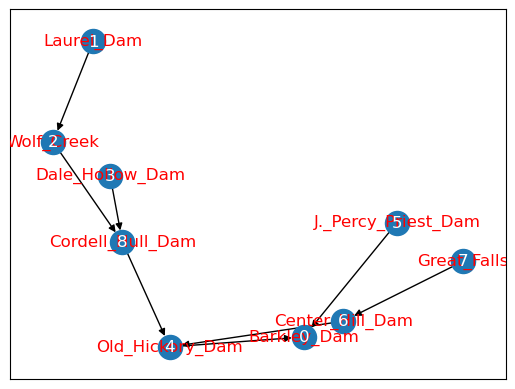

In [3]:
# quick and simple implementation without landlab

G = gnx.read_geofiles(river_network_pts_fn, river_network_fn, directed=True)
# nx.draw(G, nx.drawing.planar_layout(G))
pos = nx.drawing.spring_layout(G)
nx.draw_networkx_nodes(G, pos)
nx.draw_networkx_edges(G, pos)
nx.draw_networkx_labels(G, pos, labels={node:G.nodes[node]['name'] for node in G.nodes},font_color='red')
nx.draw_networkx_labels(G, pos,font_color='white')

In [4]:
list(nx.topological_sort(G)) # upstream most is first element

[1, 3, 5, 7, 2, 6, 8, 4, 0]

Method:

- Generate topologically sorted list of nodes. This will provide a sequence of nodes with the downstream most node at the end.
- For each Node:
    - Obtain `natural_inflow` from RAT routing results.
    - Obtain `storage_change`. In-situ (for now, later replace with satellite estimates). This will be 0 if node is USGS gage.
    - Get list of upstream nodes.
    - If any upstream nodes, for each upstream node:
        - Obtain **routed** `natural_inflow`.  ; routed = time-lagged
        - Obtain **routed** `outflow`.
    - Calculate `regulated_inflow` = `natural_inflow - sum(upstream_reservoirs['natural_inflow']) + sum(upstream_reservoirs['outflow'])`
    - Calculate `outflow` = `regulated_inflow - `

In [5]:
import xarray as xr
import pandas as pd

In [6]:
regulation_data_fn = Path("../../data-cumberland/regulation/regulation_data.nc")
regulation_data_fn.parent.mkdir(exist_ok=True)

In [7]:
# read natural_inflows of nodes/stations and store in `regulation_data`
natural_inflow_dir = Path("../../data-cumberland/tennessee/basins/cumberland/ro/rout_inflow")
insitu_dir = Path("../../data-cumberland/insitu/")  # observed ∆S, I, O

datasets_to_join = []

for node_id in G:
    node = G.nodes[node_id]
    name = node['name']

    # natural inflow
    natural_inflow_fn = natural_inflow_dir / f"{name[:5]: <5}.csv"
    natural_inflow = pd.read_csv(natural_inflow_fn, parse_dates=['date']).rename({
        'date': 'time',
        'streamflow': 'natural_inflow'
        }, axis='columns')
    natural_inflow['natural_inflow'] = natural_inflow['natural_inflow'] * (24*60*60)  # m3/s -> m3/day
    natural_inflow['node'] = node_id
    natural_inflow.set_index(['time', 'node'], inplace=True)
    natural_inflow = natural_inflow.to_xarray()
    datasets_to_join.append(natural_inflow)

    # insitu data
    insitu_fn = insitu_dir / f"{name}.csv"
    insitu = pd.read_csv(insitu_fn, parse_dates=['date']).rename({'date': 'time'}, axis=1)

    insitu['node'] = node_id

    # storage change
    if 'storage' in insitu.columns:  # it is a reservoir
        insitu['storage_change'] = (insitu['storage']*1e6).diff()   # m3/day
    else:
        insitu['storage_change'] = 0  # no storage by USGS gages

    storage_change = insitu[['time', 'node', 'storage_change']]
    storage_change.set_index(['time', 'node'], inplace=True)
    storage_change = storage_change.to_xarray()
    datasets_to_join.append(storage_change)

    # observed inflow
    obs_inflow = insitu[['time', 'node', 'inflow']].rename({'inflow': 'obs_inflow'}, axis=1)
    obs_inflow.set_index(['time', 'node'], inplace=True)
    obs_inflow = obs_inflow.to_xarray() * (24*60*60) # m3/s -> m3/day
    datasets_to_join.append(obs_inflow)

    # observed outflow (if available)
    if 'outflow' in insitu.columns:
        obs_outflow = insitu[['time', 'node', 'outflow']].rename({'outflow': 'obs_outflow'}, axis=1)
        obs_outflow.set_index(['time', 'node'], inplace=True)
        obs_outflow = obs_outflow.to_xarray() * (24*60*60) # m3/s -> m3/day
        datasets_to_join.append(obs_outflow)

regulation_data = xr.merge(datasets_to_join)
regulation_data.to_netcdf(regulation_data_fn)

Using the dataset generated above, a function can be created in the form of `R(node, time_lag)` that will provide the inflow at a time `t - time_lag`, essentially "routing" the flow based on time-lag routing scheme.

In [8]:
from dask.distributed import Client
import dask

In [9]:
client = Client(n_workers=6)
client

2023-04-19 11:04:03,844 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-worker-space/worker-8_yru3oj', purging


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 6
Total threads: 36,Total memory: 62.63 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:35044,Workers: 6
Dashboard: http://127.0.0.1:8787/status,Total threads: 36
Started: Just now,Total memory: 62.63 GiB
Comm: tcp://127.0.0.1:33978,Total threads: 6
Dashboard: http://127.0.0.1:45859/status,Memory: 10.44 GiB
Nanny: tcp://127.0.0.1:41012,


In [10]:
start_date = "2019-01-01"
end_date = "2019-12-31"
dt = '1d'

ds = xr.open_dataset(regulation_data_fn)

# add necessary dataarrays
if 'outflow' not in ds.variables:
    ds['outflow'] = xr.full_like(ds['natural_inflow'], np.nan)
if 'regulated_inflow' not in ds.variables:
    ds['regulated_inflow'] = xr.full_like(ds['natural_inflow'], np.nan)

def upstream_storage_change(ds, nodes, times):
    return 

def update(date, ds, G):
    # start calculating regulated streamflow from upstream dams
    for node in list(nx.topological_sort(G)):
        storage_change = float(ds['storage_change'].sel(node=node, time=date))
        natural_inflow = float(ds['natural_inflow'].sel(node=node, time=date))

        upstreams = list(G.predecessors(node))
        upstream_outflow = 0.0
        upstream_natural_inflow = 0.0
        if len(upstreams) > 0:
            time_lags = [date - pd.to_timedelta(round(G.get_edge_data(upstream, node)['travel_time']), 'd') for upstream in upstreams]
            upstream_outflow = sum([float(ds['outflow'].sel(node=n, time=t)) for n, t in zip(upstreams, time_lags)])
            upstream_natural_inflow = sum([float(ds['natural_inflow'].sel(node=n, time=t)) for n, t in zip(upstreams, time_lags)])
        
        regulated_inflow = max([0, float(natural_inflow - upstream_natural_inflow + upstream_outflow)])
        outflow = max([0, regulated_inflow - storage_change])

        ds['regulated_inflow'].loc[dict(node=node, time=date)] = regulated_inflow
        ds['outflow'].loc[dict(node=node, time=date)] = outflow

dates = pd.date_range(start_date, end_date, freq=dt)#[:10]

with tqdm(total=len(dates)) as pbar:
    for date in dates:
        update(date, ds, G)
        pbar.update(1)
        pbar.set_description(f"{date}")

  0%|          | 0/365 [00:00<?, ?it/s]

In [11]:
subset = ds.sel(time=slice(start_date, end_date))
subset

<xarray.Dataset>
Dimensions:           (time: 365, node: 9)
Coordinates:
  * time              (time) datetime64[ns] 2019-01-01 2019-01-02 ... 2019-12-31
  * node              (node) int64 0 1 2 3 4 5 6 7 8
Data variables:
    natural_inflow    (time, node) float64 5.84e+08 1.361e+07 ... 8.096e+07
    storage_change    (time, node) float64 ...
    obs_inflow        (time, node) float64 ...
    obs_outflow       (time, node) float64 ...
    outflow           (time, node) float64 0.0 1.287e+07 1.187e+08 ... 0.0 0.0
    regulated_inflow  (time, node) float64 0.0 1.361e+07 ... 1.639e+07 3.565e+05

In [12]:
import matplotlib.pyplot as plt

{0: Text(-1.0, 0.29441896059487604, '0'),
 1: Text(0.9524293211407749, -0.06348472650849624, '1'),
 2: Text(0.5779531460193905, -0.05815729602501835, '2'),
 3: Text(0.4847971222780225, -0.2515229653945781, '3'),
 4: Text(-0.4033398438007189, 0.08503350641883421, '4'),
 5: Text(-0.7937462713068798, 0.1358514376985642, '5'),
 6: Text(-0.1115318179409899, -0.09423736151267229, '6'),
 7: Text(0.09485437315688368, 0.024643628305513074, '7'),
 8: Text(0.19858397045351894, -0.07254518357702251, '8')}

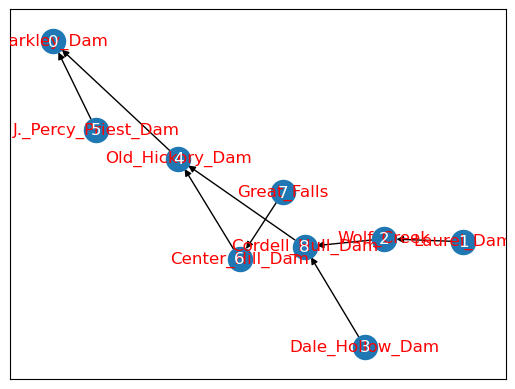

In [13]:
pos = nx.drawing.spring_layout(G, k=0.1)
nx.draw_networkx_nodes(G, pos)
nx.draw_networkx_edges(G, pos)
nx.draw_networkx_labels(G, pos, labels={node:G.nodes[node]['name'] for node in G.nodes},font_color='red')
nx.draw_networkx_labels(G, pos,font_color='white')

In [14]:
import scipy.stats as stats

def get_stats(obs, mod):
    corr, corr_p = stats.pearsonr(obs, mod)
    nse = 1 - (np.sum((obs - mod)**2)/np.sum((obs - np.mean(obs))**2))
    nse1 = 1 - (np.sum(np.abs(obs - mod))/np.sum(np.abs(obs - np.mean(obs))))
    rmse = np.sqrt(np.sum((obs-mod)**2)/len(mod))
    norm_rmse = rmse/(np.max(obs) - np.min(obs))
    mae = np.sum(np.abs(mod-obs))/len(mod)
    norm_mae = mae/(np.max(obs) - min(obs))
    kge = 1 - np.sqrt((corr-1)**2 +  (np.std(mod)/np.std(obs) - 1)**2 + (np.mean(mod)/np.mean(obs) - 1)**2) 

    return {'pearson-r': corr, 'pearson-r p-val': corr_p, 'nse': nse, 'nse1': nse1, 'rmse': rmse, 'norm_rmse': norm_rmse, 'mae': mae, 'norm_mae': norm_mae, 'kge': kge}

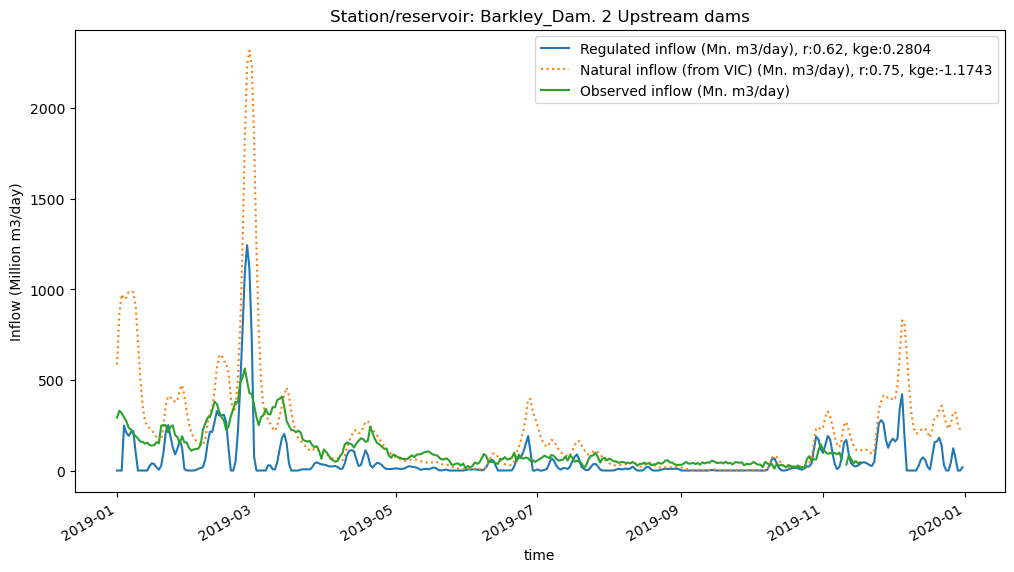

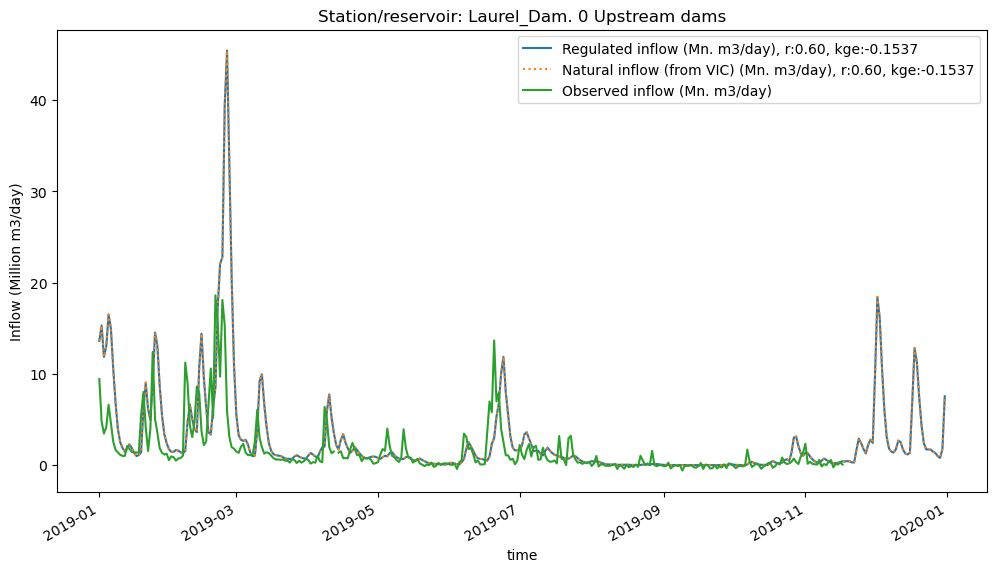

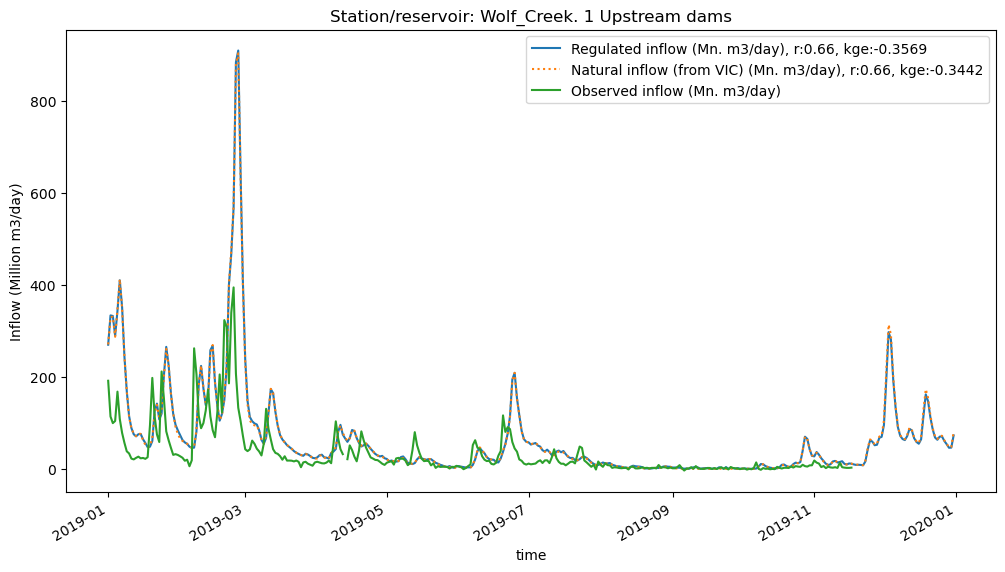

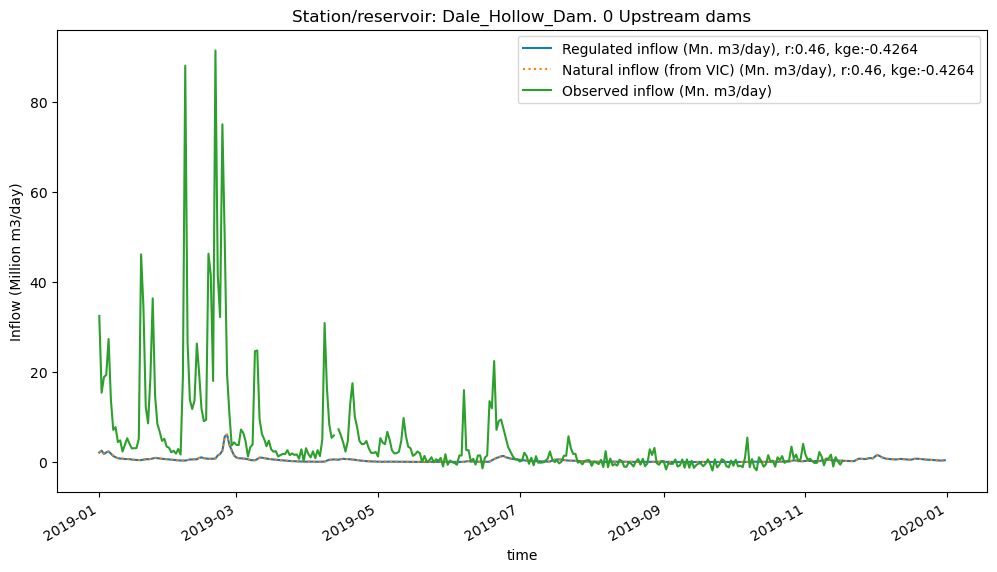

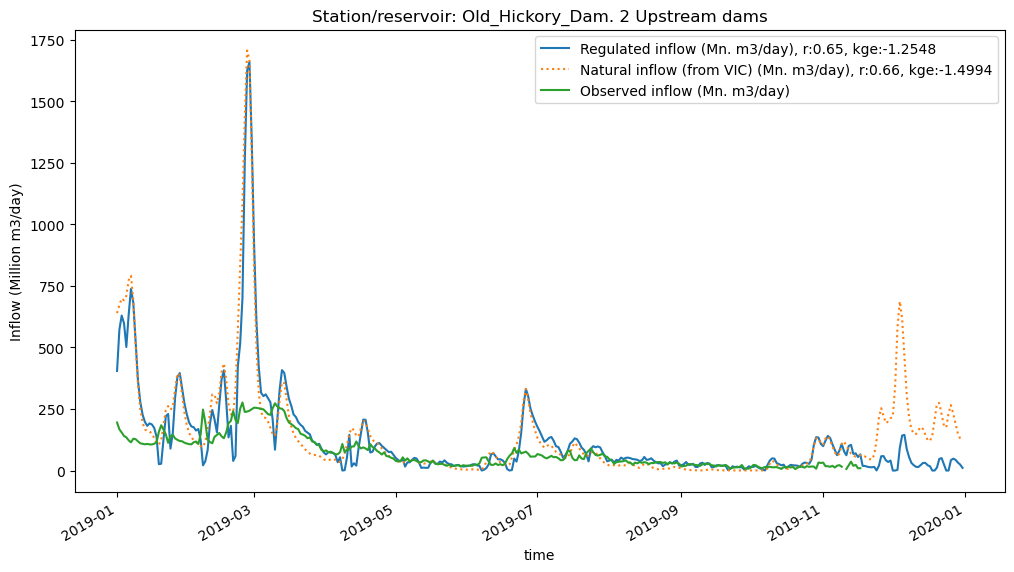

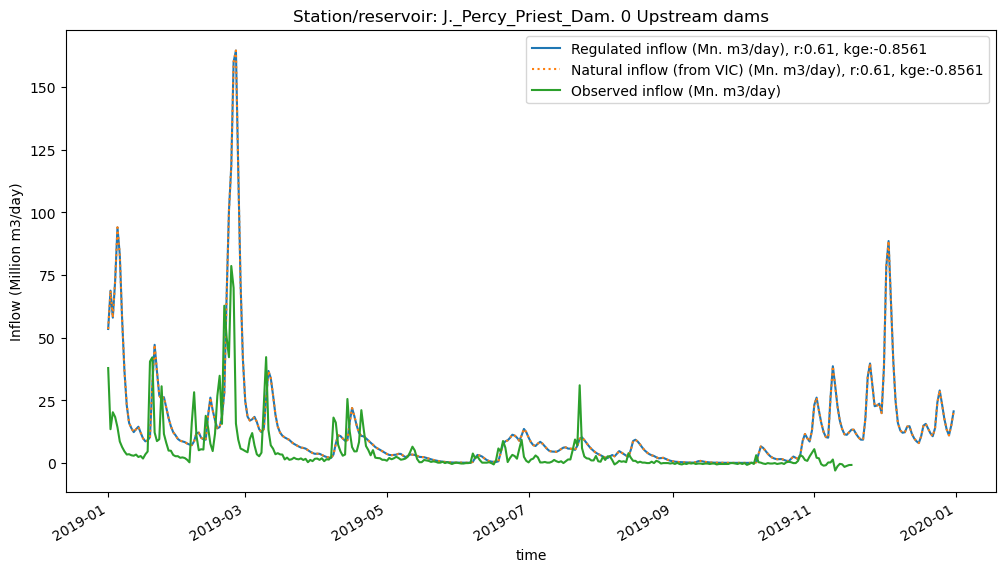

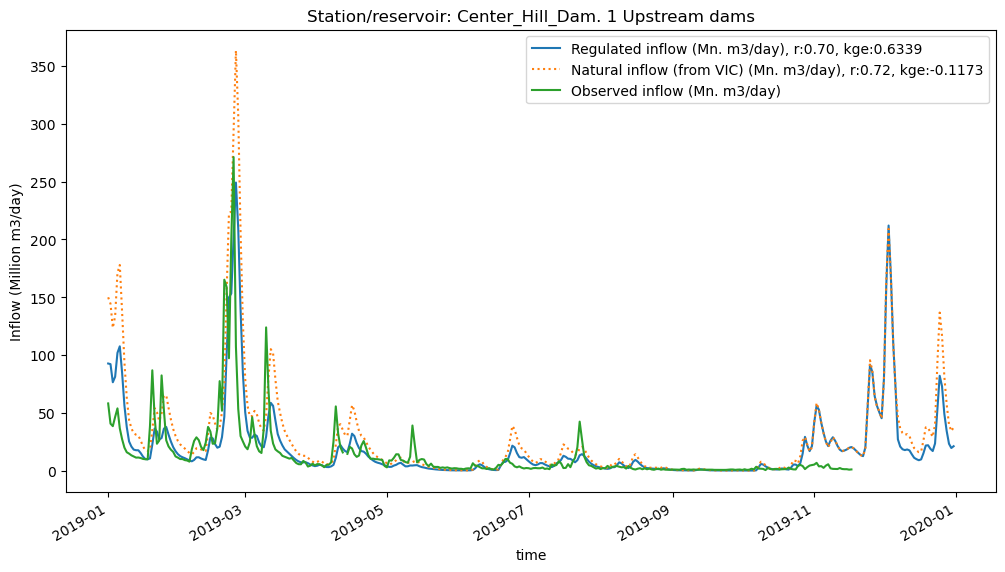

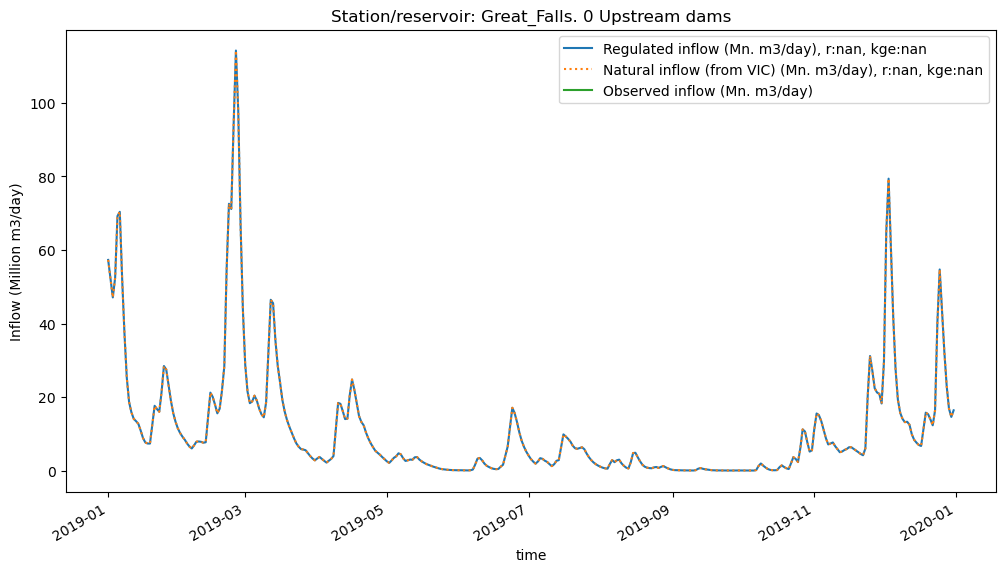

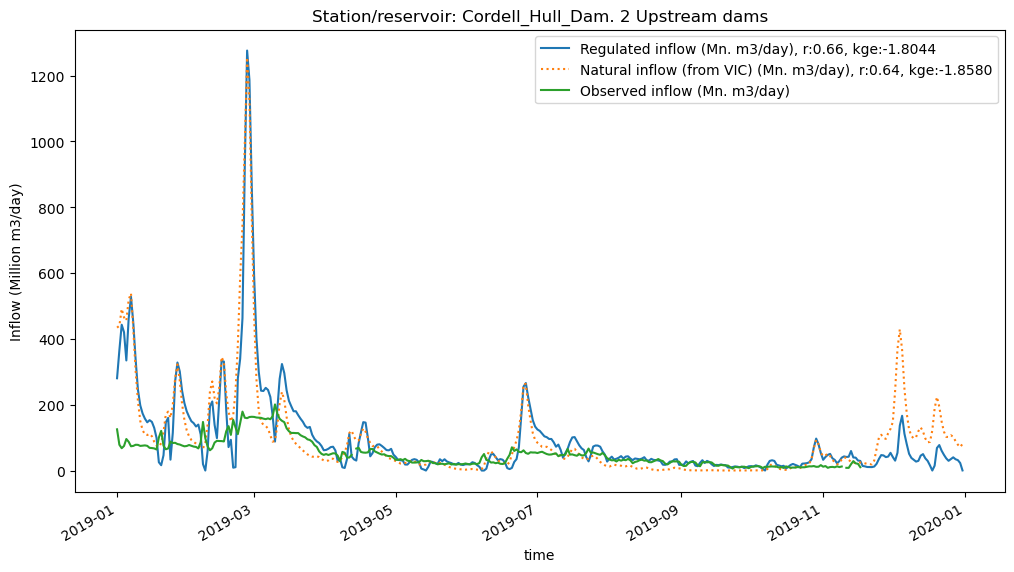

In [15]:
for node in G.nodes:
    f, ax = plt.subplots(figsize=(12, 6))

    reg_inflow = (subset['regulated_inflow'].sel(node=node) * 1e-6)
    nat_inflow = (subset['natural_inflow'].sel(node=node) * 1e-6)
    obs_inflow = (subset['obs_inflow'].sel(node=node) * 1e-6)

    r = {
        "regulated" : np.nan,
        "natural": np.nan
    }
    nse = {
        "regulated" : np.nan,
        "natural": np.nan
    }
    norm_rmse = {
        "regulated" : np.nan,
        "natural": np.nan
    }
    norm_mae = {
        "regulated" : np.nan,
        "natural": np.nan
    }
    kge = {
        "regulated" : np.nan,
        "natural": np.nan
    }

    no_nan_reg_obs = xr.merge([reg_inflow, obs_inflow]).dropna(dim="time")
    if no_nan_reg_obs.count('time')['obs_inflow'] > 2:
        reg_inflow_stats = get_stats(no_nan_reg_obs['obs_inflow'].data, no_nan_reg_obs['regulated_inflow'].data)
        r['regulated'] = reg_inflow_stats['pearson-r']
        nse['regulated'] = reg_inflow_stats['nse']
        norm_rmse['regulated'] = reg_inflow_stats['norm_rmse']
        norm_mae['regulated'] = reg_inflow_stats['norm_mae']
        kge['regulated'] = reg_inflow_stats['kge']

    no_nan_nat_obs = xr.merge([nat_inflow, obs_inflow]).dropna(dim="time")
    if no_nan_nat_obs.count('time')['obs_inflow'] > 2:
        nat_inflow_stats = get_stats(no_nan_nat_obs['obs_inflow'].data, no_nan_nat_obs['natural_inflow'].data)
        r['natural'] = nat_inflow_stats['pearson-r']
        nse['natural'] = nat_inflow_stats['nse']
        norm_rmse['natural'] = nat_inflow_stats['norm_rmse']
        norm_mae['natural'] = nat_inflow_stats['norm_mae']
        kge['natural'] = nat_inflow_stats['kge']

    reg_inflow.plot(ax=ax, label=f'Regulated inflow (Mn. m3/day), r:{r["regulated"]:.2f}, kge:{kge["regulated"]:.4f}')
    nat_inflow.plot(ax=ax, label=f'Natural inflow (from VIC) (Mn. m3/day), r:{r["natural"]:.2f}, kge:{kge["natural"]:.4f}', linestyle='dotted')
    obs_inflow.plot(ax=ax, label=f'Observed inflow (Mn. m3/day)')
    ax.set_title(f'Station/reservoir: {G.nodes[node]["name"]}. {len(list(G.predecessors(node)))} Upstream dams')
    ax.set_ylabel("Inflow (Million m3/day)")
    ax.legend()

    save_dir = Path("../../results/01_time_lagged")
    save_dir.mkdir(exist_ok=True)
    save_fn = save_dir / f"{node:0>2}_{G.nodes[node]['name']}.png"
    plt.savefig(save_fn)